El objetivo de esta práctica guiada es comprobar la implementación de un algoritmo KNN en Python. En particular, vamos a emplear el fichero público Adult Income (adult.csv), enlazado desde Github, que incluye un total de 15 variables independientes acerca de distintas personas (educación, tipo de trabajo, raza, género, edad, etc) y, como variable dependiente, si ganan más o menos de 50K USD anuales (dos clases).

Comenzamos importando las librerías y funciones necesarias y el fichero de datos a procesar.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import DistanceMetric

# Cargar datos desde GitHub
url = "https://github.com/crisurdiales/DataMining4SmartCities/raw/main/adult.csv"
knn_df_original = pd.read_csv(url)

#voy a añadir una columna con los indices de los datos para, cuando los muestree
#aleatoriamente, poder referir siempre cualquier vector al df original. Lo hago
#despues del encoding para que no me codifique estos  valores
knn_df_original['original_index'] = knn_df_original.index

print(knn_df_original.head())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

Para tranajar con knn, necesito codificar las variables no numéricas como valores numéricos. Usaremos la función LabelEncoder, que simplemente asigna un número distinto a cada etiqueta distinta del conjunto.

In [2]:
knn_df = knn_df_original.copy()
# Convertir variables categóricas a numéricas para poder procesarlas
label_encoders = {}
for column in knn_df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    knn_df[column] = label_encoders[column].fit_transform(knn_df[column])
# Visualizar las primeras filas del DataFrame
print(knn_df.head())

   age  workclass  fnlwgt  education  educational-num  marital-status  \
0   25          4  226802          1                7               4   
1   38          4   89814         11                9               2   
2   28          2  336951          7               12               2   
3   44          4  160323         15               10               2   
4   18          0  103497         15               10               4   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0           7             3     2       1             0             0   
1           5             0     4       1             0             0   
2          11             0     4       1             0             0   
3           7             0     2       1          7688             0   
4           0             3     4       0             0             0   

   hours-per-week  native-country  income  original_index  
0              40              39       0               0  
1 

Dado que el proceso requiere calcular las distancias de todos los datos de entrenamiento 2 a 2, para reducir el tiempo de cómputo nos quedamos con un conjunto reducido de los mismos.

Luego separaremos este conjunto entre datos de entrenamiento y datos de prueba para evaluar el impacto del overfitting.

In [3]:
# Seleccionar un subconjunto del dataset y dividirlo aleatoriamente entre datos de entrenamiento y de test
numsamples = 1000
np.random.seed(2)
knn_small = knn_df.sample(n=numsamples)
train_size = int(0.7 * numsamples)
train_knn = knn_small.iloc[:train_size]
test_knn = knn_small.iloc[train_size:]

Calculamos las distancias dos a dos de los datos en el conjunto de entrenamiento, dejando fuera la variable dependiente y la columna de indices.

In [4]:
# Calcular la matriz de distancias con Gower. Con 1000 va rápido, a partir de ahí, tarda
distance_metric = DistanceMetric.get_metric('pyfunc', func=lambda x, y: (x != y).astype(int).mean())
d_pw = distance_metric.pairwise(train_knn.drop(['income', 'original_index'], axis=1).values)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


Definimos una función moda y la función knn_f. Esta última sirve para calcular a quá clases pertenecen los k datos más cercanos al que estamos analizando y asignarle a este último la moda del conjunto.

In [5]:
# Función moda
from statistics import mode

def getmode(v):
    return mode(v)

# Función KNN
def knn_f(train, test, k, d_pw):
    n_train = train.shape[0]
    n_test = test.shape[0]
    classes = np.zeros(n_test)

    for i in range(n_test):
        closest_indices = np.argsort(d_pw[i])[:k]
        closest_classes = train.iloc[closest_indices, -2].values
        classes[i] = getmode(closest_classes)

    return classes

In [6]:
chosen_k = int(np.sqrt(train_knn.shape[0]))

results = knn_f(train_knn, test_knn, chosen_k, d_pw)



In [7]:
# Agregar la columna 'predicted_income' al DataFrame test_knn
test_knn['predicted_income'] = results

# Unir los DataFrames utilizando 'original_index' como índice
final_result = knn_df_original.merge(test_knn[['predicted_income']], left_on='original_index', right_index=True)

# Mapear los valores numéricos a las categorías originales
final_result['predicted_income'] = final_result['predicted_income'].map({0: '<=50K', 1: '>50K'})

#eliminar la columna auxiliar original_index
final_result.drop(columns=['original_index'], inplace=True)

# Imprimir final_result para verificar
print(final_result.head())



     age    workclass  fnlwgt     education  educational-num  \
11    36  Federal-gov  212465     Bachelors               13   
33    23    Local-gov  258120  Some-college               10   
151   27      Private  221561          11th                7   
157   22      Private  537222     Bachelors               13   
198   19      Private  355313       HS-grad                9   

         marital-status         occupation   relationship   race  gender  \
11   Married-civ-spouse       Adm-clerical        Husband  White    Male   
33   Married-civ-spouse    Protective-serv        Husband  White    Male   
151  Married-civ-spouse      Other-service           Wife  Black  Female   
157       Never-married              Sales  Not-in-family  White    Male   
198       Never-married  Machine-op-inspct  Not-in-family  White  Female   

     capital-gain  capital-loss  hours-per-week native-country income  \
11              0             0              40  United-States  <=50K   
33          

<ipython-input-7-fc68d0578b5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_knn['predicted_income'] = results


In [8]:
# Filtrar las filas donde 'income' y 'predicted_income' no coinciden
fallos = final_result[final_result['income'] != final_result['predicted_income']]

# Imprimir fallos para verificar
print(fallos.head())

      age  workclass  fnlwgt     education  educational-num  \
497    35    Private   98776       HS-grad                9   
802    27  Local-gov  157449       HS-grad                9   
823    22    Private   37932    Assoc-acdm               12   
1361   29  Local-gov  187981  Some-college               10   
2235   48    Private  172822  Some-college               10   

          marital-status       occupation   relationship   race gender  \
497        Never-married  Exec-managerial  Not-in-family  White   Male   
802   Married-civ-spouse     Tech-support        Husband  White   Male   
823        Never-married  Exec-managerial  Not-in-family  White   Male   
1361  Married-civ-spouse    Other-service        Husband  White   Male   
2235            Divorced     Craft-repair      Unmarried  White   Male   

      capital-gain  capital-loss  hours-per-week native-country income  \
497              0             0              60  United-States  <=50K   
802              0          

Analicemos los casos en que el algoritmo se equivoca más en la predicción, para comprobar si hay algún patrón.

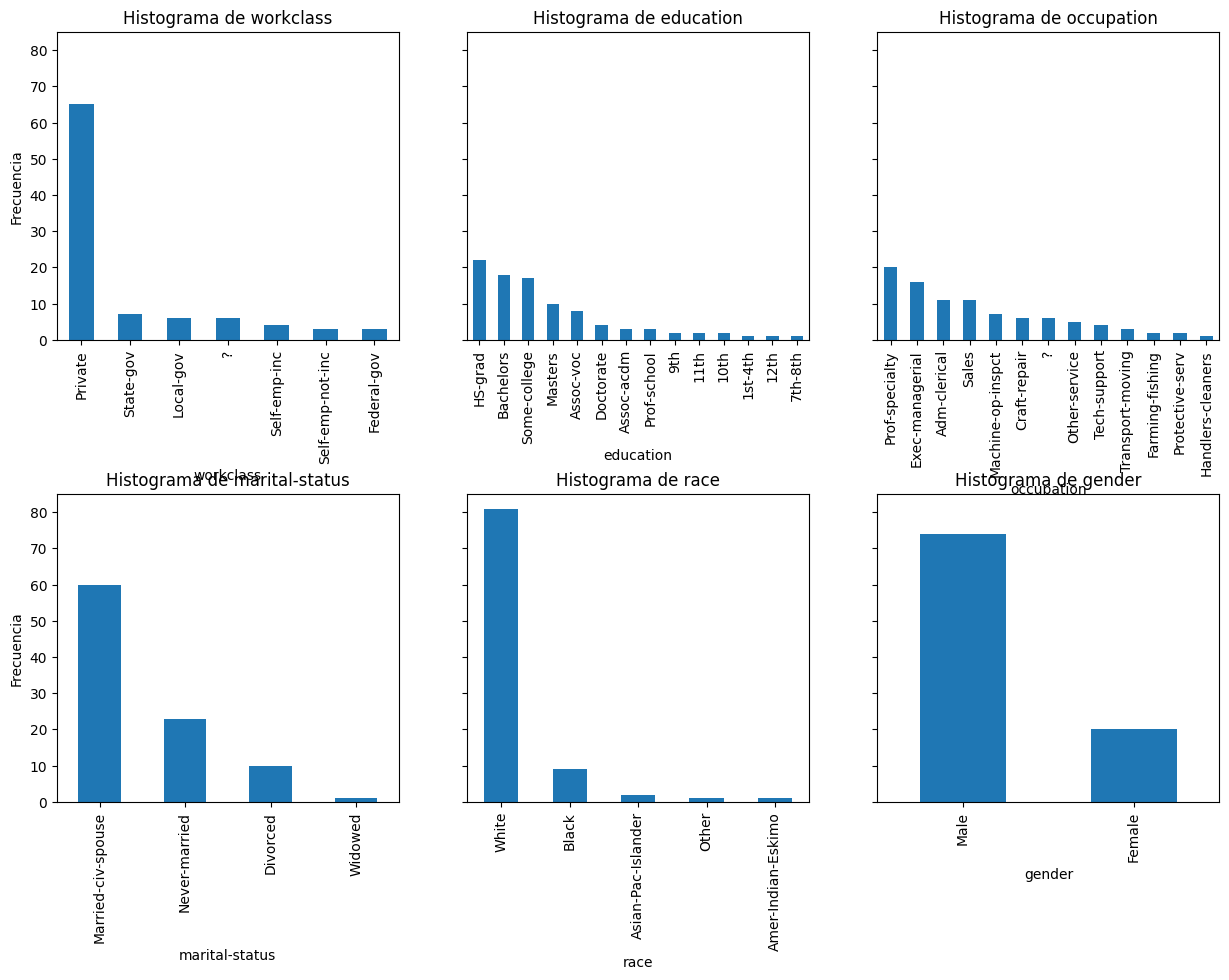

In [9]:
import matplotlib.pyplot as plt

# Crear subplots para cada columna
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# Histograma de la columna 'workclass'
fallos['workclass'].value_counts().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Histograma de workclass')
axes[0, 0].set_xlabel('workclass')
axes[0, 0].set_ylabel('Frecuencia')

# Histograma de la columna 'education'
fallos['education'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Histograma de education')
axes[0, 1].set_xlabel('education')
axes[0, 1].set_ylabel('Frecuencia')

# Histograma de la columna 'occupation'
fallos['occupation'].value_counts().plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Histograma de occupation')
axes[0, 2].set_xlabel('occupation')
axes[0, 2].set_ylabel('Frecuencia')

# Histograma de la columna 'marital-status'
fallos['marital-status'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Histograma de marital-status')
axes[1, 0].set_xlabel('marital-status')
axes[1, 0].set_ylabel('Frecuencia')

# Histograma de la columna 'race'
fallos['race'].value_counts().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Histograma de race')
axes[1, 1].set_xlabel('race')
axes[1, 1].set_ylabel('Frecuencia')

# Histograma de la columna 'gender'
fallos['gender'].value_counts().plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Histograma de gender')
axes[1, 2].set_xlabel('gender')
axes[1, 2].set_ylabel('Frecuencia')

# Ajustar el espacio vertical entre los subplots
plt.subplots_adjust(hspace=0.5)

# Mostrar el gráfico
plt.show()


A primera vista cabría concluir que la predicción falla más en: i) empleos en la privada que en la pública, lo que resulta bastante obvio; ii) para personas sin carrera universitaria, probablemente debido a la dispersión de empleos en que pueden acabar; iii) para varones de raza blanca; y vi) para personas casadas. Esto podria explicarse por una mayor dispersión de empleos y, por tanto, de salarios, en estos casos, o también por condiciones económicas distintas. Para aclararlo harían falta análisis adicionales.

Un ejemplo de análisis adicional sería representar las probabilidades condicionadas de ganar más o menos de 50K en función de las variables donde vemos más variedad. Si analizamos los resultados sobre el dataframe de fallos, podemos ver si el algoritmo se equivoca hacia arriba o hacia abajo. El código a continuación muestra, por ejemplo, que en general se subestima el salario de variones y raza blanca y se sobreestima en todos los casos el de la raza innuit y los que se enmarcan en "Otras". También se ha subestiomado en de trabajadores del gobierno y autónomos, divorciados y casados, pero se sobreestima el de solteros y viudos -curiosamente, esto apuntaría a que se paga más a personas con familia por el hecho de tenerla y no necesariamente por productividad-. Hay que tener en cuenta, no obstante, que en este análisis sólo observamos los fallos, ya que si representamos el dataframe entero, la gran mayoría de las personas están por debajo de 50k.

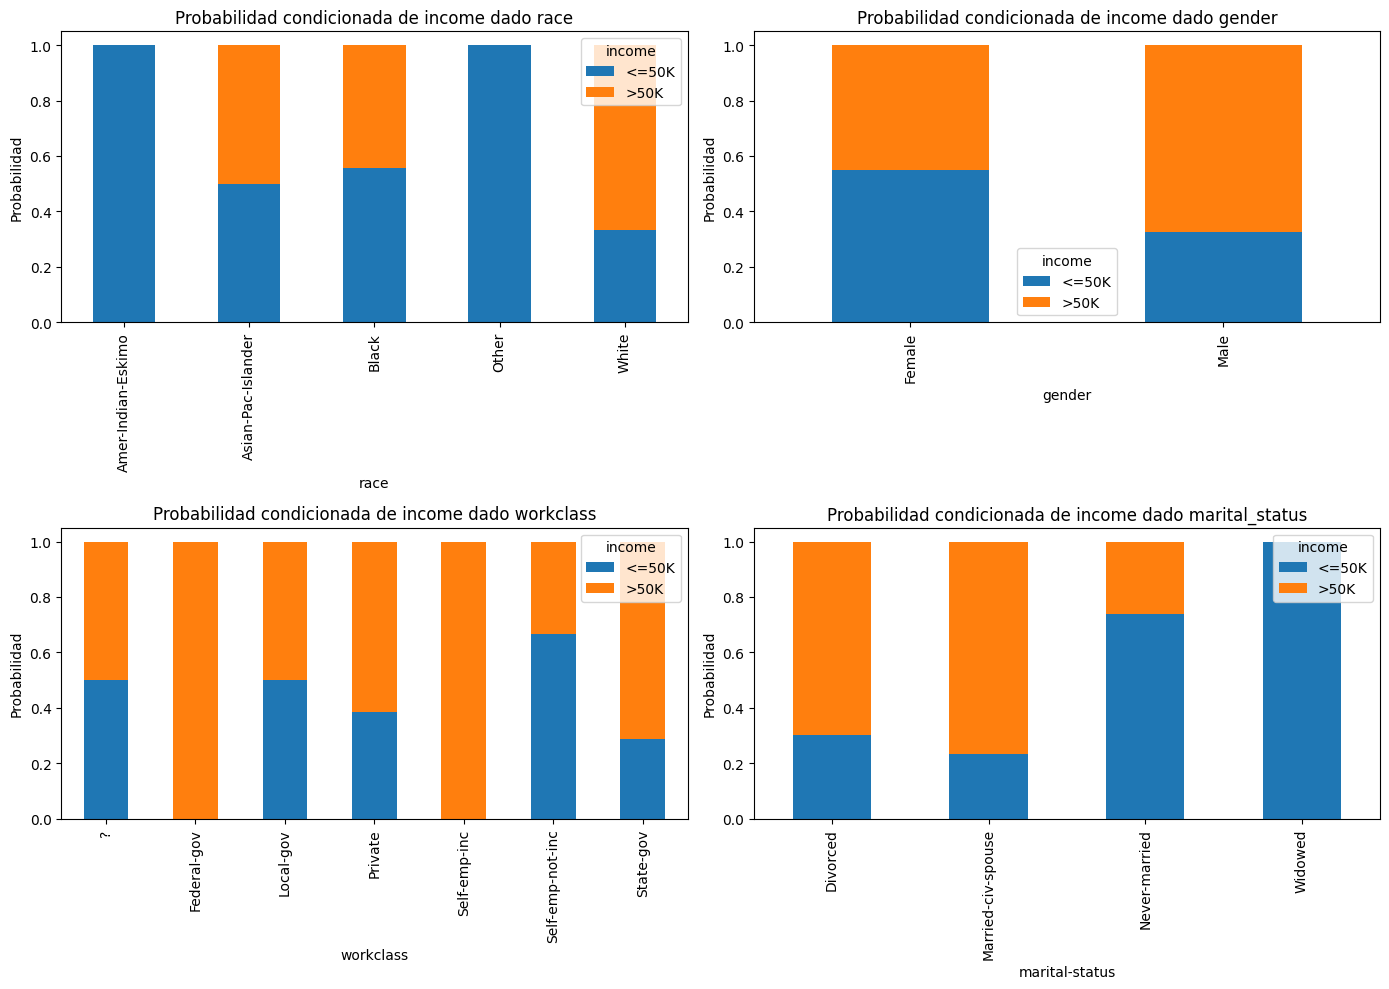

In [14]:
# Calcula la probabilidad condicionada de income dado race
race_income_prob = fallos.groupby(['race', 'income']).size().unstack()
race_income_prob = race_income_prob.div(race_income_prob.sum(axis=1), axis=0)

# Calcula la probabilidad condicionada de income dado gender
gender_income_prob = fallos.groupby(['gender', 'income']).size().unstack()
gender_income_prob = gender_income_prob.div(gender_income_prob.sum(axis=1), axis=0)

# Calcula la probabilidad condicionada de income dado workclass
workclass_income_prob = fallos.groupby(['workclass', 'income']).size().unstack()
workclass_income_prob = workclass_income_prob.div(workclass_income_prob.sum(axis=1), axis=0)

# Calcula la probabilidad condicionada de income dado marital_status
marital_income_prob = fallos.groupby(['marital-status', 'income']).size().unstack()
marital_income_prob = marital_income_prob.div(marital_income_prob.sum(axis=1), axis=0)

# Graficar las probabilidades condicionadas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

race_income_prob.plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Probabilidad condicionada de income dado race')
axes[0, 0].set_ylabel('Probabilidad')

gender_income_prob.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Probabilidad condicionada de income dado gender')
axes[0, 1].set_ylabel('Probabilidad')

workclass_income_prob.plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Probabilidad condicionada de income dado workclass')
axes[1, 0].set_ylabel('Probabilidad')

marital_income_prob.plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Probabilidad condicionada de income dado marital_status')
axes[1, 1].set_ylabel('Probabilidad')

plt.tight_layout()
plt.show()
